###**Imports and Setting up Enivornment**

In [1]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.3 MB/s eta 0:00:00


In [2]:
#Allowing access to my google drive

from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gradio as gr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc

###**Loading the pre-trained Model and organize data**

In [5]:
# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False

# Adding Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)

# Two Labels - Golden Eagle or Not
predictions = Dense(2, activation = 'softmax')(x)

# Make new model - ge for golden eagle
model = Model(inputs = base_model.input, outputs = predictions)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining checkpointing, to restore the best epoch
model_checkpoint = ModelCheckpoint(
    filepath='/content/finished_models/best_model.keras',  # Path to save the model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Data preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data preprocessing for the test set
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/GoldenEagleData/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed = 14
)

# Load the validation data
valid_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/GoldenEagleData/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed = 14
)

# Train the model
model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=10,
    callbacks=[model_checkpoint]
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 1226 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7198 - loss: 1.2104
Epoch 1: val_accuracy improved from -inf to 0.95455, saving model to /content/finished_models/best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 282s 6s/step - accuracy: 0.7228 - loss: 1.1951 - val_accuracy: 0.9545 - val_loss: 0.1265
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9537 - loss: 0.1238
Epoch 2: val_accuracy did not improve from 0.95455
39/39 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9537 - loss: 0.1240 - val_accuracy: 0.9545 - val_loss: 0.1125
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9629 - loss: 0.0953
Epoch 3: val_accuracy did not improve from 0.95455
39/39 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9631 - loss: 0.0952 - val_accuracy: 0.9364 - val_loss: 0.1596
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9890 - loss: 0.0506
Epoch 4: val_accuracy did not improve from 0.95455
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9888 - loss: 0.

###**Validation Test Results**

In [6]:
# Gets the predictions of the model on the validation set
predictions = model.predict(valid_generator)
pred = np.argmax(predictions, axis=1)

actual = valid_generator.classes
labels = list(valid_generator.class_indices.keys())

# Creates a confusion matrix
cnf_mtx = tf.math.confusion_matrix(actual, pred)
print(cnf_mtx)

# Shows a classifcation report on the results from the model
print(classification_report(actual, pred, target_names=labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
tf.Tensor(
[[15 29]
 [28 38]], shape=(2, 2), dtype=int32)
                precision    recall  f1-score   support

   GoldenEagle       0.35      0.34      0.34        44
NotGoldenEagle       0.57      0.58      0.57        66

      accuracy                           0.48       110
     macro avg       0.46      0.46      0.46       110
  weighted avg       0.48      0.48      0.48       110



###**Test Set Results**

In [7]:
# Load the testing data
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/GoldenEagleData/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed = 14
)

Found 282 images belonging to 2 classes.


In [8]:
# Gets the predictions of the model on the test set
predictions = model.predict(test_generator)
pred = np.argmax(predictions, axis=1)

actual = test_generator.classes
labels = list(test_generator.class_indices.keys())

# Creates a confusion matrix
cnf_mtx = tf.math.confusion_matrix(actual, pred)
print(cnf_mtx)

# Shows a classifcation report on the results from the model
print(classification_report(actual, pred, target_names=labels))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
tf.Tensor(
[[  2  18]
 [ 18 244]], shape=(2, 2), dtype=int32)
                precision    recall  f1-score   support

   GoldenEagle       0.10      0.10      0.10        20
NotGoldenEagle       0.93      0.93      0.93       262

      accuracy                           0.87       282
     macro avg       0.52      0.52      0.52       282
  weighted avg       0.87      0.87      0.87       282



###**ROC Curve on the Test Set Results**

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


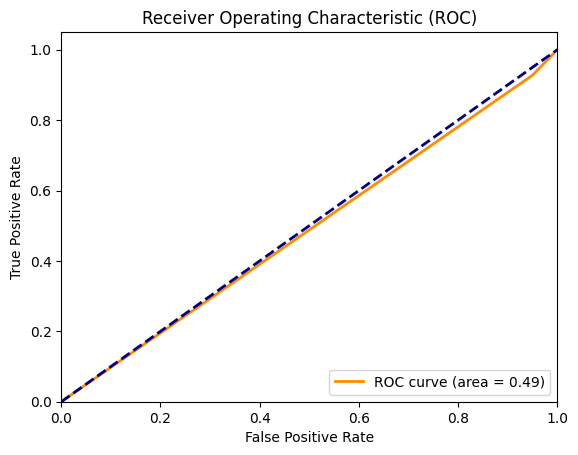

In [15]:
# Calculates the roc curve from the model results
predictions = model.predict(test_generator)
pred = np.argmax(predictions, axis=1)

actual = test_generator.classes

fpr, tpr, _ = roc_curve(actual, pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

###**Gradio**

In [ ]:
labels = ['GoldenEagle', 'NotGoldenEagle']

def classify_image(img):
    """
    Takes an image, preprocesses it, feeds it to the trained MobileNetV2 model
    (model), and returns the prediction as a dictionary of the two classes.
    """
    # Resize the image to 224x224 pixels
    img = cv2.resize(img, (224, 224))
    # Reshape the image to match the model's input shape
    img = img.reshape(1, 224, 224, 3)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    # Make prediction
    prediction = model.predict(img).flatten()
    # Map predictions to labels
    return {labels[i]: float(prediction[i]) for i in range(2)}

# Define Gradio interface components
image_input = gr.Image(type="numpy", label="Upload an Image")  # Gradio input component for image
label_output = gr.Label(num_top_classes=2, label="Prediction")  # Gradio output component for labels

# Launch Gradio interface
gr.Interface(fn=classify_image, inputs=image_input, outputs=label_output, title="Golden Eagle Classifier").launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5b55c3c2559b485523.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
